In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vocdevkit/VOCdevkit/VOC2012/SegmentationObject/2010_002106.png
/kaggle/input/vocdevkit/VOCdevkit/VOC2012/CSV_Annotations/output.csv
/kaggle/input/vocdevkit/VOCdevkit/VOC2012/Annotations/2011_006424.xml
/kaggle/input/vocdevkit/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt
/kaggle/input/vocdevkit/VOCdevkit/VOC2012/ImageSets/Main/diningtable_train.txt
/kaggle/input/vocdevkit/VOCdevkit/VOC2012/ImageSets/Layout/val.txt
/kaggle/input/vocdevkit/VOCdevkit/VOC2012/ImageSets/Action/playinginstrument_trainval.txt
/kaggle/input/vocdevkit/VOCdevkit/VOC2012/JPEGImages/2007_005304.jpg
/kaggle/input/vocdevkit/VOCdevkit/VOC2012/SegmentationClass/2010_002106.png


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import torchvision
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
Kaggle = True
if Kaggle:
    data_root = '/kaggle/input/vocdevkit'
else:
    data_root = '~/Documents/code/ml/dataset'

In [4]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



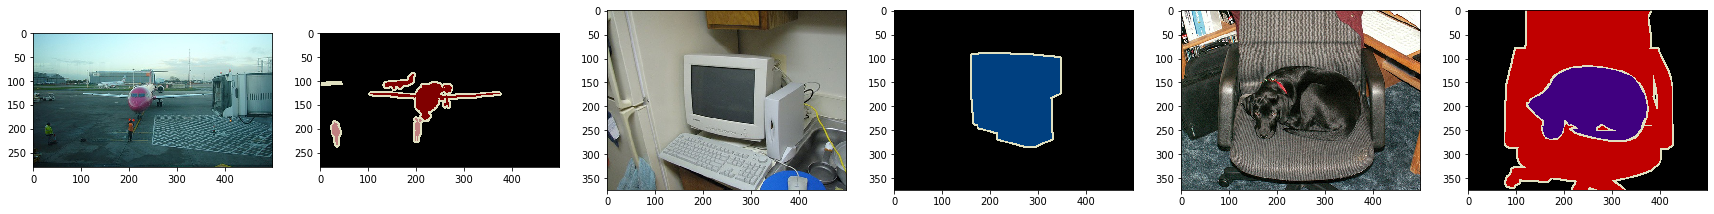

In [5]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

voc_train = torchvision.datasets.VOCSegmentation(data_root, year='2012', image_set='train', transform=transform, download=False)

plt.rcParams['figure.figsize'] = (30.0, 30.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

count = 3
fix, axs = plt.subplots(ncols=count*2, squeeze=False)
for i in range(count):
    img = Image.open(voc_train.images[i]).convert("RGB")
    axs[0, i*2].imshow(img)
    img = Image.open(voc_train.masks[i]).convert("RGB")
    axs[0, i*2+1].imshow(img)

In [6]:
# from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/dilated_convnet')

# channels_input = None
# channels_c = None

# vgg16 = models.vgg16()
# # front_end = nn.Sequential(*list(vgg16.features)[:23])
# front_end = nn.Sequential(nn.Conv2d(16,16,(1,1)))
# writer.add_graph(vgg16)
# writer.close()

In [7]:
class FrontEnd_VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(FrontEnd_VGG, self).__init__()
        self.features = features
        self.fc6 = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, dilation=4),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.fc7 = nn.Sequential(
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.finnal = nn.Conv2d(4096, num_classes, kernel_size=1)

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.finnal(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, dilations, batch_norm=False):
    layers = []
    in_channels = 3
    dilation = 0
    layer_index = 0
    for v in cfg:
        if v == 'S':
            dilation = dilations[layer_index]
            layer_index = layer_index + 1
            continue
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            if dilation == 0:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, dilation=dilation)
            
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


def test_FrontEnd_VGG():
    x = torch.zeros((1,3,900,900), dtype=dtype)
    dilations = [0, 0, 0, 0, 2]
    cfg = ['S', 64, 64, 'M', 'S', 128, 128, 'M', 'S', 256, 256, 256, 'M', 'S', 512, 512, 512, 'S', 512, 512, 512]
    features = make_layers(cfg, dilations, batch_norm=True)
    model = FrontEnd_VGG(features)
    scores = model(x)
    print('res:')
    print(scores.size())

test_FrontEnd_VGG()


res:
torch.Size([1, 1000, 66, 66])


In [19]:
class ContextNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_pre = nn.Sequential(
            nn.Conv2d(21, 42, padding=33, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        
        layers = []
        output_channel = 42
        input_channel = 42
        for i in range(5):
#             print(input_channel, output_channel)
            layers += [nn.Conv2d(input_channel, output_channel, kernel_size=3, dilation = 2**i), nn.BatchNorm2d(output_channel), nn.ReLU(inplace=True)]
            input_channel = output_channel
            output_channel = input_channel * 2
        
        self.conv = nn.Sequential(*layers)
        
        output_channel = int(output_channel/2)
        
        self.fc1 = nn.Sequential(
            nn.Conv2d(output_channel, output_channel, kernel_size=3),
            nn.ReLU(True),
        )

        self.fc_finnal = nn.Sequential(
            nn.Conv2d(output_channel, 21, kernel_size=1),
            nn.Softmax2d()
        )

        self._initialize_weights()
        
    def forward(self, x):
        x = self.conv_pre(x)
        x = self.conv(x)
        x = self.fc1(x)
        x = self.fc_finnal(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def test_contextNet():
    x = torch.zeros((1,21,66,66), dtype=dtype)
    model = ContextNet()
    scores = model(x)
    print('res:')
    print(scores.size())

test_contextNet()

672
res:
torch.Size([1, 21, 66, 66])


In [ ]:
def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [ ]:
model = None
optimizer = None
learning_rate = 1e-2
optimizer = optim.Adam(model.parameters(), lr=learning_rate)